In [ ]:
import pandas as pd
import numpy as np

In [2]:
from tqdm.notebook import tqdm
import plotly.express as px
import os
from datetime import datetime
import time
import seaborn as sns
import sweetviz as sv
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

import sklearn


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
all_feature_list = [folder for folder in os.listdir(".") if "." not in folder]
#all_feature_list = [feature for feature in all_feature_list if "_60min" in feature]
all_feature_list

['AROON_120min',
 'AROON_240min',
 'AROON_360min',
 'AROON_480min',
 'AROON_600min',
 'AROON_60min',
 'AROON_90min',
 'BB_120min',
 'BB_240min',
 'BB_360min',
 'BB_480min',
 'BB_600min',
 'BB_60min',
 'BB_90min',
 'EMA_120min',
 'EMA_240min',
 'EMA_360min',
 'EMA_480min',
 'EMA_600min',
 'EMA_60min',
 'EMA_90min',
 'High_120min',
 'High_240min',
 'High_360min',
 'High_480min',
 'High_600min',
 'High_60min',
 'High_90min',
 'Low_120min',
 'Low_240min',
 'Low_360min',
 'Low_480min',
 'Low_600min',
 'Low_60min',
 'Low_90min',
 'MACD_120min',
 'MACD_240min',
 'MACD_360min',
 'MACD_480min',
 'MACD_600min',
 'MACD_60min',
 'MACD_90min',
 'MA_120min',
 'MA_240min',
 'MA_360min',
 'MA_480min',
 'MA_600min',
 'MA_60min',
 'MA_90min',
 'ROC_Close_120min',
 'ROC_Close_240min',
 'ROC_Close_360min',
 'ROC_Close_480min',
 'ROC_Close_600min',
 'ROC_Close_60min',
 'ROC_Close_90min',
 'RSI_120min',
 'RSI_240min',
 'RSI_360min',
 'RSI_480min',
 'RSI_600min',
 'RSI_60min',
 'RSI_90min',
 'STCO_120min',
 

In [4]:
fx_pair, year = "EURUSD", 2019

targets = [file for file in os.listdir("../Target_Bank/Regression/{}".format(fx_pair)) if "{}".format(year) in file]

targets

['EURUSD_2019_12_candle_future.csv',
 'EURUSD_2019_18_candle_future.csv',
 'EURUSD_2019_3_candle_future.csv',
 'EURUSD_2019_6_candle_future.csv']

In [5]:
def data_set_builder(fx_pair, years, features):
    """
    fx_pair: a given currency pair: "EURUSD", "GBPCHF", etc...
    years: if int, a single year, else, a list of years.
    features: a list of features, as described in its file structure. E.G "ROC_Low_90min"
    """
    if type(years) == int: years = [years]
    df = None
    for year in tqdm(years):
        temp_df = pd.read_csv("../Cleaned_OHLC_FOREX_Data_10_min/{}/{}_{}_10min.csv".format(fx_pair, fx_pair,  year)).drop(columns =['Unnamed: 0'])
        
        targets = [file for file in os.listdir("../Target_Bank/Regression/{}".format(fx_pair)) if "{}".format(year) in file]        
        
        for file in targets:
            target_df = pd.read_csv("../Target_Bank/Regression/{}/".format(fx_pair) + file).drop(columns =['Unnamed: 0'])
            temp_df = pd.concat([temp_df, target_df], axis=1)
        
        for feature in features:
            feature_df = pd.read_csv("{}/{}/{}_{}_{}_standardized.csv".format(feature, fx_pair, feature, fx_pair, year)).drop(columns =['Unnamed: 0'])
            feature_df.fillna(0, inplace = True)
            temp_df = pd.concat([temp_df, feature_df], axis=1)
            
        if type(df) == None:
            df = temp_df.copy()
        else: 
            df = pd.concat([df, temp_df], axis=0)
            
    drop_the_index = None
    df_nans = df[df.isna().any(axis=1)]
    if len(df_nans) >= 1:
        print("")
        print("Amount of rows with Nans:", len(df_nans))
        drop_the_index = df_nans.index.values.tolist()
        print("Dropping index in {} year-span {}-{} : {}".format(fx_pair,years[0], years[-1], drop_the_index))
        df.drop(drop_the_index, inplace = True)
        
    df.drop(columns = ['Date_time','Open','High','Low','Close'], inplace = True)
    df.reset_index(inplace = True, drop = True )
    return df

clean_df = data_set_builder('EURUSD', [i for i in range(2012,2020)], all_feature_list)

clean_df


,12_candle_target,18_candle_target,3_candle_target,6_candle_target,AROON_120min_up,AROON_120min_down,AROON_240min_up,AROON_240min_down,AROON_360min_up,AROON_360min_down,AROON_480min_up,AROON_480min_down,AROON_600min_up,AROON_600min_down,AROON_60min_up,AROON_60min_down,AROON_90min_up,AROON_90min_down,BB_120min_upper,BB_120min_lower,BB_240min_upper,BB_240min_lower,BB_360min_upper,BB_360min_lower,BB_480min_upper,BB_480min_lower,BB_600min_upper,BB_600min_lower,BB_60min_upper,BB_60min_lower,BB_90min_upper,BB_90min_lower,EMA_120min,EMA_240min,EMA_360min,EMA_480min,EMA_600min,EMA_60min,EMA_90min,High_120min,High_240min,High_360min,High_480min,High_600min,High_60min,High_90min,Low_120min,Low_240min,Low_360min,Low_480min,Low_600min,Low_60min,Low_90min,MACD_120min,MACD_120min_signal,MACD_120min_crossover,MACD_240min,MACD_240min_signal,MACD_240min_crossover,MACD_360min,MACD_360min_signal,MACD_360min_crossover,MACD_480min,MACD_480min_signal,MACD_480min_crossover,MACD_600min,MACD_600min_signal,MACD_600min_crossover,MACD_60min,MACD_60min_signal,MACD_60min_crossover,MACD_90min,MACD_90min_signal,MACD_90min_crossover,MA_120min,MA_240min,MA_360min,MA_480min,MA_600min,MA_60min,MA_90min,ROC_Close_120min,ROC_Close_240min,ROC_Close_360min,ROC_Close_480min,ROC_Close_600min,ROC_Close_60min,ROC_Close_90min,RSI_120min,RSI_240min,RSI_360min,RSI_480min,RSI_600min,RSI_60min,RSI_90min,STCO_120min,STCO_240min,STCO_360min,STCO_480min,STCO_600min,STCO_60min,STCO_90min
0,9.4,15.9,0.4,6.2,0.833333,0.833333,0.916667,0.916667,0.944444,0.944444,0.958333,0.958333,0.966667,0.966667,0.666667,0.666667,0.777778,0.777778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.170609,0.122521,0.101401,0.088895,0.080365,0.239380,0.196231,-1.153737,-0.827127,-0.683997,-0.599184,-0.541895,-1.617666,-1.327062,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
1,9.8,11.8,-0.6,9.1,1.000000,0.666667,1.000000,0.833333,1.000000,0.888889,1.000000,0.916667,1.000000,0.933333,1.000000,0.333333,1.000000,0.555556,0.013912,-0.006644,0.009917,-0.004736,0.008154,-0.003894,0.007113,-0.003397,0.006410,-0.003061,0.019542,-0.009333,0.016023,-0.007652,0.006278,0.006278,0.006278,0.006278,0.006278,0.006278,0.006278,0.217139,0.155936,0.129055,0.113139,0.102283,0.304666,0.249749,-1.145780,-0.821423,-0.679280,-0.595052,-0.538158,-1.606510,-1.317910,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006278,0.006278,0.006278,0.006278,0.006278,0.006278,0.006278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000
2,12.6,4.5,-6.5,5.3,0.833333,0.500000,0.916667,0.750000,0.944444,0.833333,0.958333,0.875000,0.966667,0.900000,0.666667,0.000000,0.777778,0.333333,0.087027,-0.324440,0.062035,-0.231268,0.051006,-0.190153,0.044498,-0.165888,0.040099,-0.149489,0.122244,-0.455730,0.100231,-0.373664,-0.205070,-0.205070,-0.205070,-0.205070,-0.205070,-0.205070,-0.205070,0.023265,0.016707,0.013827,0.012122,0.010959,0.032643,0.026759,-1.344700,-0.964031,-0.797210,-0.698359,-0.631588,-1.885418,-1.546713,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.221199,0.147466,0.073733,0.000000,0.000000,0.000000,-0.205070,-0.205070,-0.205070,-0.205070,-0

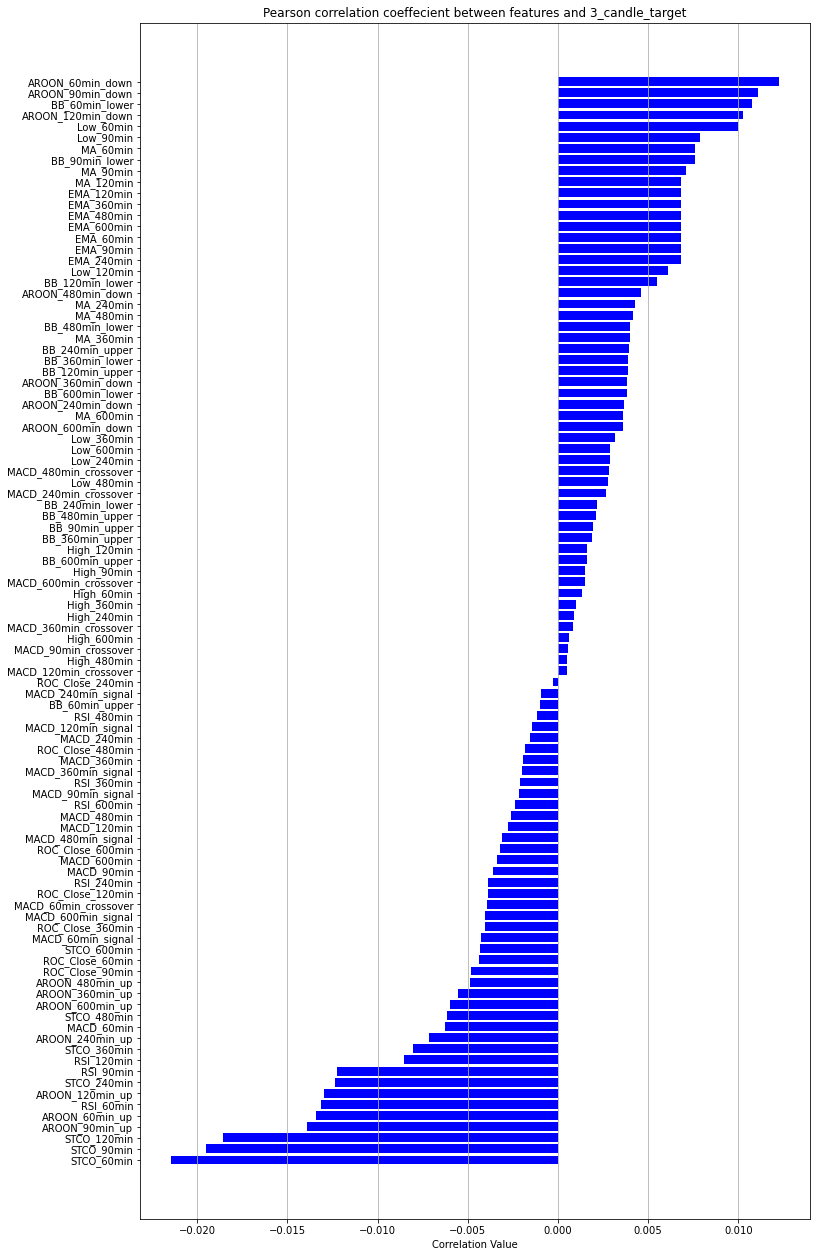

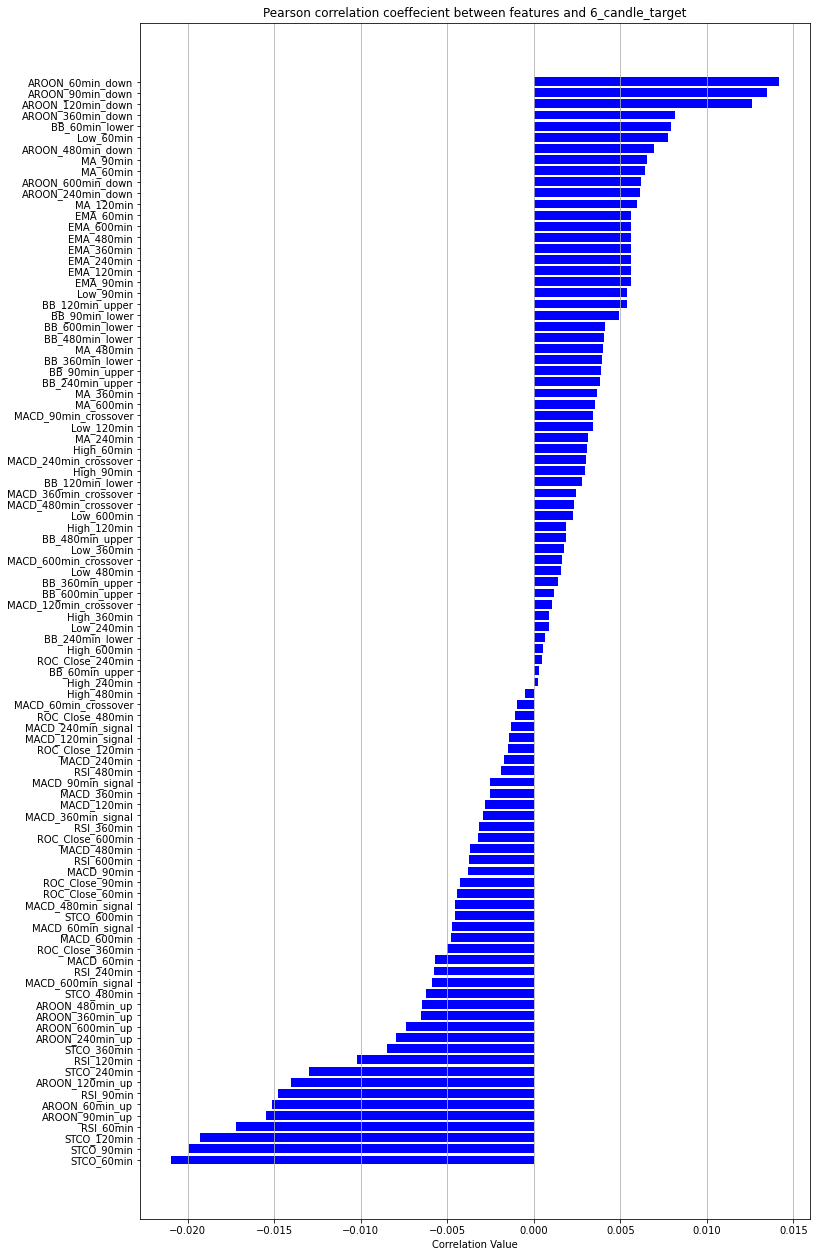

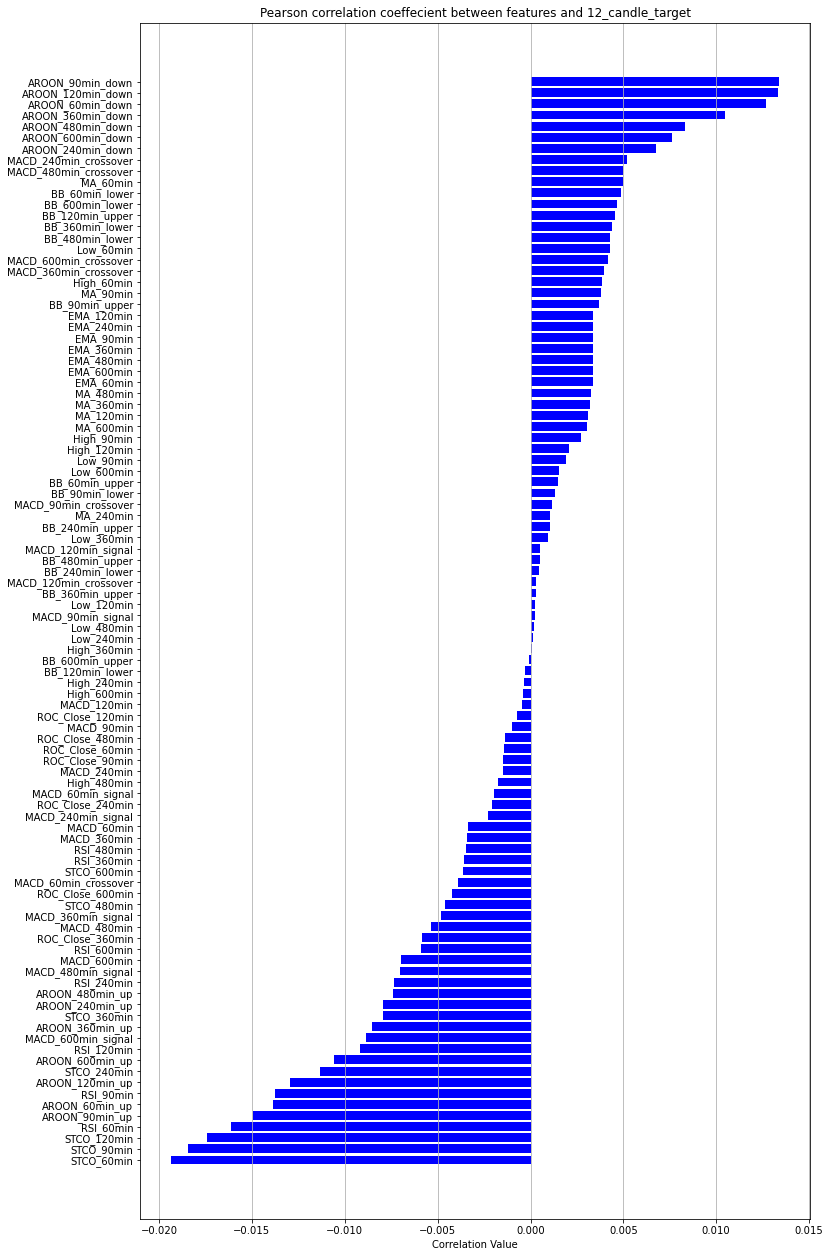

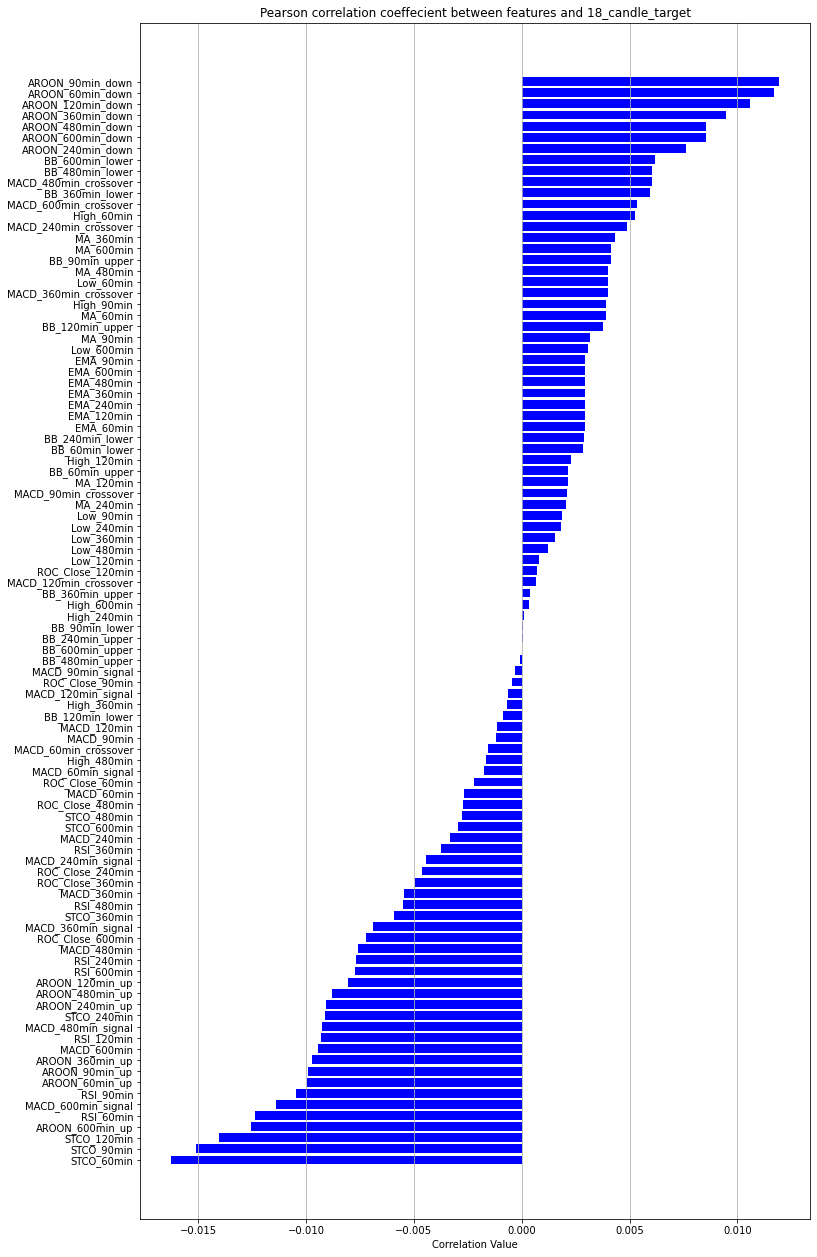

In [6]:
def show_inportance(df, target_candles):
    """
    target_candles: an int describing the future candles to be analyzed
    """    
    targets_to_drop = [i for i in df if "target" in i]
    targets_to_drop.remove(f"{target_candles}_candle_target") 
    
    df.drop(columns= targets_to_drop, inplace = True)
    
    importances = df.drop("{}_candle_target".format(target_candles), axis=1).apply(lambda x: x.corr(df["{}_candle_target".format(target_candles)]))
    indices = np.argsort(importances)
    #print(importances[indices])

    temp_df = df.drop("{}_candle_target".format(target_candles), axis=1)
    names = list(temp_df.columns.values.tolist()) 
    
    plt.figure(figsize=(12,22))
    plt.title('Pearson correlation coeffecient between features and' + " {}_candle_target".format(target_candles))
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [names[i] for i in indices])
    plt.xlabel('Correlation Value')
    plt.grid(True, axis='x')
    plt.show()
    
for future_candle in [3,6,12,18]:
    show_inportance(data_set_builder('EURUSD', [i for i in range(2012,2020)], all_feature_list), future_candle)

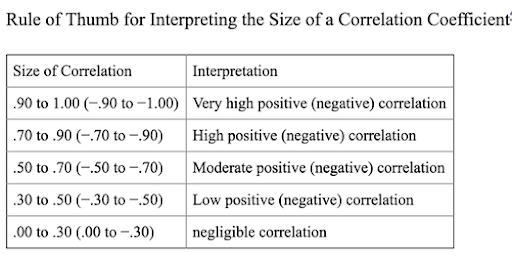


In [6]:
clean_df = data_set_builder('EURUSD', [i for i in range(2012,2020)], all_feature_list)
clean_df

,12_candle_target,18_candle_target,3_candle_target,6_candle_target,AROON_120min_up,AROON_120min_down,AROON_240min_up,AROON_240min_down,AROON_360min_up,AROON_360min_down,AROON_480min_up,AROON_480min_down,AROON_600min_up,AROON_600min_down,AROON_60min_up,AROON_60min_down,AROON_90min_up,AROON_90min_down,BB_120min_upper,BB_120min_lower,BB_240min_upper,BB_240min_lower,BB_360min_upper,BB_360min_lower,BB_480min_upper,BB_480min_lower,BB_600min_upper,BB_600min_lower,BB_60min_upper,BB_60min_lower,BB_90min_upper,BB_90min_lower,EMA_120min,EMA_240min,EMA_360min,EMA_480min,EMA_600min,EMA_60min,EMA_90min,High_120min,High_240min,High_360min,High_480min,High_600min,High_60min,High_90min,Low_120min,Low_240min,Low_360min,Low_480min,Low_600min,Low_60min,Low_90min,MACD_120min,MACD_120min_signal,MACD_120min_crossover,MACD_240min,MACD_240min_signal,MACD_240min_crossover,MACD_360min,MACD_360min_signal,MACD_360min_crossover,MACD_480min,MACD_480min_signal,MACD_480min_crossover,MACD_600min,MACD_600min_signal,MACD_600min_crossover,MACD_60min,MACD_60min_signal,MACD_60min_crossover,MACD_90min,MACD_90min_signal,MACD_90min_crossover,MA_120min,MA_240min,MA_360min,MA_480min,MA_600min,MA_60min,MA_90min,ROC_Close_120min,ROC_Close_240min,ROC_Close_360min,ROC_Close_480min,ROC_Close_600min,ROC_Close_60min,ROC_Close_90min,RSI_120min,RSI_240min,RSI_360min,RSI_480min,RSI_600min,RSI_60min,RSI_90min,STCO_120min,STCO_240min,STCO_360min,STCO_480min,STCO_600min,STCO_60min,STCO_90min
0,9.4,15.9,0.4,6.2,0.833333,0.833333,0.916667,0.916667,0.944444,0.944444,0.958333,0.958333,0.966667,0.966667,0.666667,0.666667,0.777778,0.777778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.170609,0.122521,0.101401,0.088895,0.080365,0.239380,0.196231,-1.153737,-0.827127,-0.683997,-0.599184,-0.541895,-1.617666,-1.327062,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
1,9.8,11.8,-0.6,9.1,1.000000,0.666667,1.000000,0.833333,1.000000,0.888889,1.000000,0.916667,1.000000,0.933333,1.000000,0.333333,1.000000,0.555556,0.013912,-0.006644,0.009917,-0.004736,0.008154,-0.003894,0.007113,-0.003397,0.006410,-0.003061,0.019542,-0.009333,0.016023,-0.007652,0.006278,0.006278,0.006278,0.006278,0.006278,0.006278,0.006278,0.217139,0.155936,0.129055,0.113139,0.102283,0.304666,0.249749,-1.145780,-0.821423,-0.679280,-0.595052,-0.538158,-1.606510,-1.317910,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006278,0.006278,0.006278,0.006278,0.006278,0.006278,0.006278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000
2,12.6,4.5,-6.5,5.3,0.833333,0.500000,0.916667,0.750000,0.944444,0.833333,0.958333,0.875000,0.966667,0.900000,0.666667,0.000000,0.777778,0.333333,0.087027,-0.324440,0.062035,-0.231268,0.051006,-0.190153,0.044498,-0.165888,0.040099,-0.149489,0.122244,-0.455730,0.100231,-0.373664,-0.205070,-0.205070,-0.205070,-0.205070,-0.205070,-0.205070,-0.205070,0.023265,0.016707,0.013827,0.012122,0.010959,0.032643,0.026759,-1.344700,-0.964031,-0.797210,-0.698359,-0.631588,-1.885418,-1.546713,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.221199,0.147466,0.073733,0.000000,0.000000,0.000000,-0.205070,-0.205070,-0.205070,-0.205070,-0

Feature ranking:
1  . feature RSI_480min                 0.023377
2  . feature RSI_600min                 0.023367
3  . feature RSI_360min                 0.022731
4  . feature BB_60min_lower             0.020855
5  . feature MACD_60min_crossover       0.018446
6  . feature ROC_Close_360min           0.018344
7  . feature RSI_240min                 0.018040
8  . feature Low_60min                  0.017934
9  . feature ROC_Close_60min            0.017743
10 . feature ROC_Close_600min           0.017712
11 . feature ROC_Close_240min           0.017220
12 . feature BB_60min_upper             0.016972
13 . feature RSI_120min                 0.016884
14 . feature RSI_60min                  0.016582
15 . feature ROC_Close_480min           0.016566
16 . feature ROC_Close_120min           0.015744
17 . feature MACD_600min_signal         0.015303
18 . feature High_60min                 0.015270
19 . feature RSI_90min                  0.014854
20 . feature ROC_Close_90min            0.014836
21 

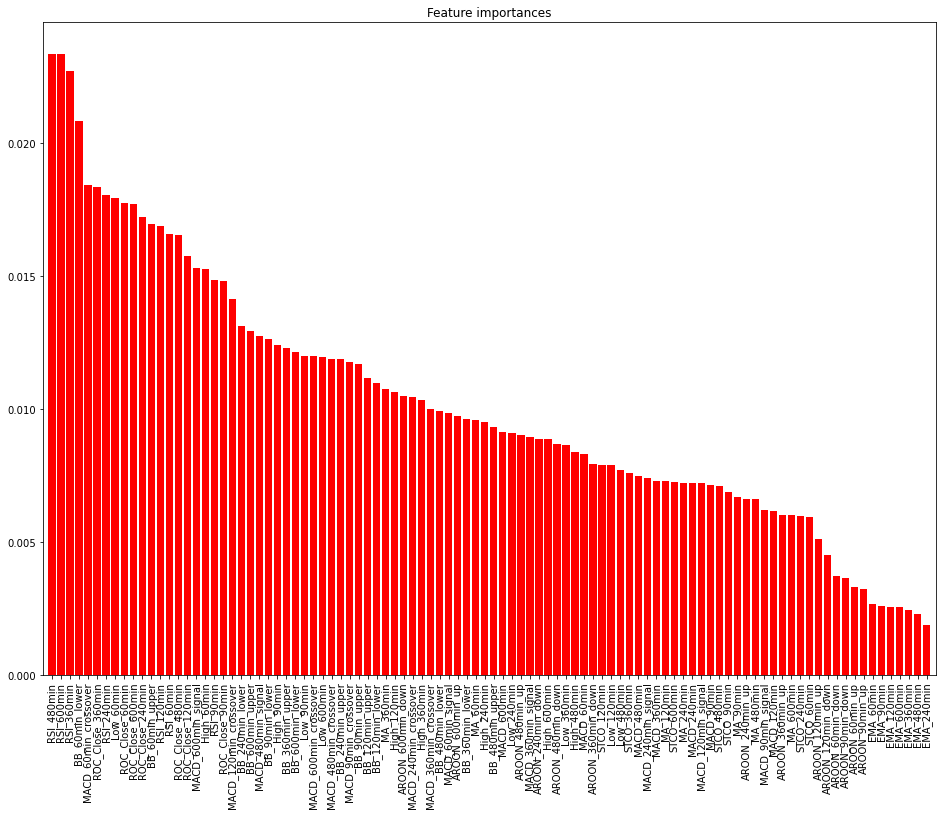

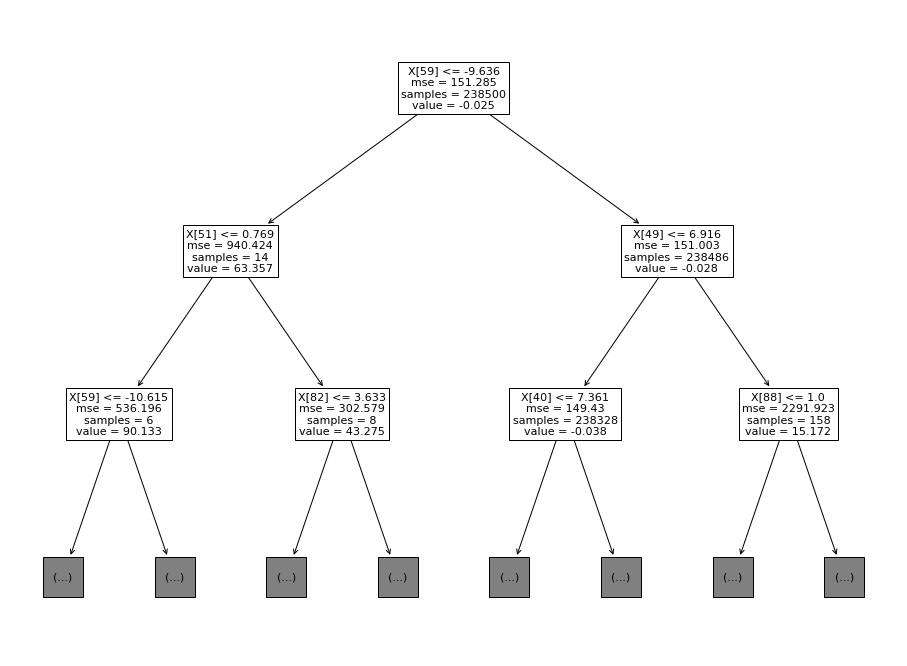


 Time elapsed:  110.86792397499084


In [8]:
def tree_regressor(df, target_candles):
    
    start = time.time()
    
    targets_to_drop = [i for i in df if "target" in i]
    targets_to_drop.remove(f"{target_candles}_candle_target") 
    
    df.drop(columns= targets_to_drop, inplace = True)
    
    target = "{}_candle_target".format(target_candles)
    
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns= [target]), df[target], 
                                                                test_size=0.20, random_state=42, shuffle=True)
    
    # Build a tree and compute the impurity-based feature importances
    tree = DecisionTreeRegressor(random_state=42)
    tree.fit(X_train, y_train) 
    importances = tree.feature_importances_
    indices = np.argsort(importances)[::-1]
        
    # Print the feature ranking
    print("Feature ranking:")
    
    col_names = [col for col in df.drop(columns= [target])]

    for f in range(X_train.shape[1]):
        print("{:<3}. feature {:<25}  {:.6f}".format(f + 1, col_names[indices[f]], importances[indices[f]]))

    # Plot the impurity-based feature importances of the forest
    indices_names = [df.drop("{}".format(target), axis=1).columns[i] for i in indices]
    plt.figure(figsize=(16,12))
    plt.title("Feature importances")
    plt.bar(indices_names, importances[indices],
            color="r", align="center")
    plt.xticks(range(X_train.shape[1]), indices_names, rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    
    plt.show()
    
    plt.figure(figsize=(16,12))
    sklearn.tree.plot_tree(tree, max_depth= 2)
    plt.show()
    
    print("\n Time elapsed: ", time.time() - start)

    
    return tree 

for future_candle in [6]:#,6,12,24,36]:
    tree_regressor(clean_df, future_candle)

# Correlations of features and instances of target values larger than 10.

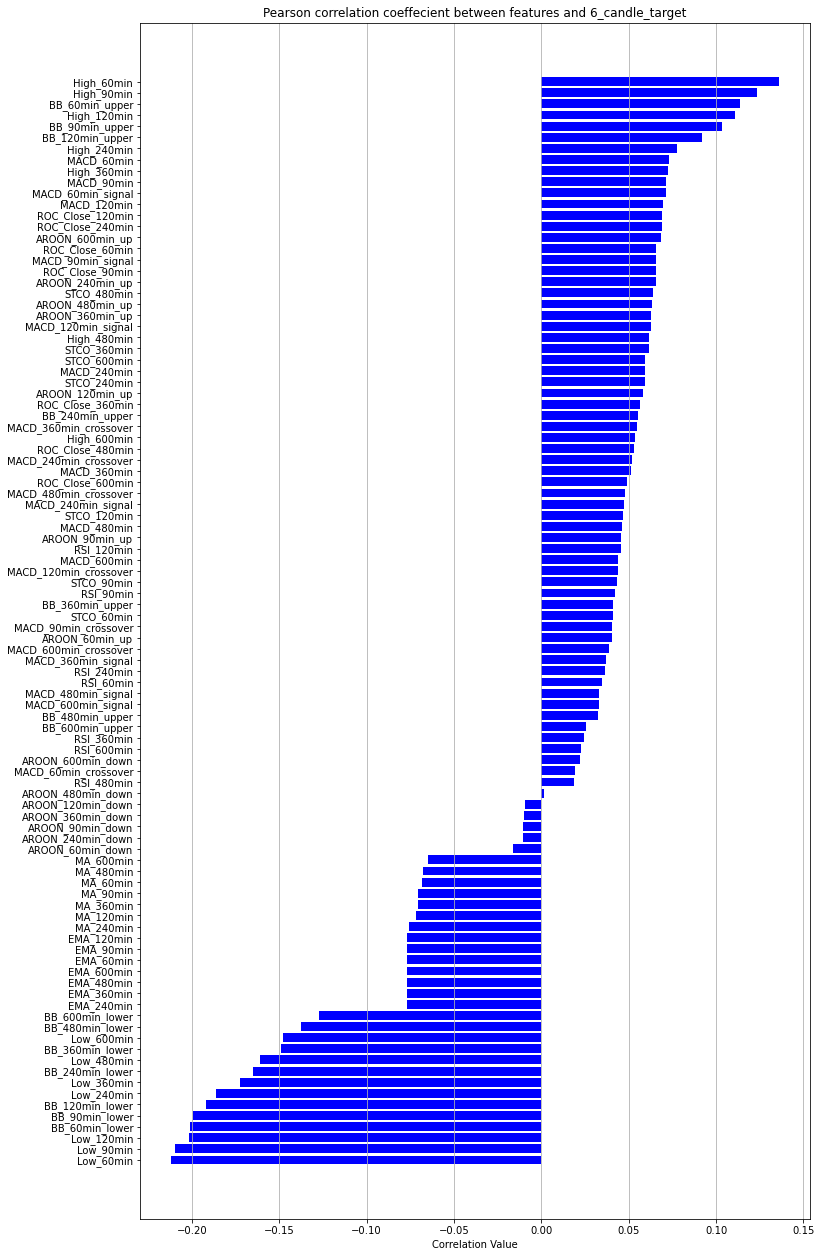

In [17]:
future_candle = 6

df = data_set_builder('EURUSD', [i for i in range(2012,2020)], all_feature_list)
vol_df = df[df['6_candle_target'] >= 10].reset_index(drop = True)

show_inportance(vol_df, future_candle)